# Comedy Bang Bang Podcast Best Of - Decision Tree Model

In [352]:
# Define some exclusions for PEP8 that don't apply when the Jupyter Notebook
#   is exported to .py file
# pylint: disable=pointless-statement
# pylint: disable=fixme
# pylint: disable=expression-not-assigned
# pylint: disable=missing-module-docstring
# pylint: disable=invalid-name

import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import sklearn.metrics as sklm

# Setting custom parameters for this model

In [353]:
# percentage of training data to use for test
TEST_SIZE = 0.33

# random seed
RANDOM_STATE = 1234

# the name for the column that indicates the label/target
# the training CSV file should have headers
LABEL_COLUMN_NAME = "label"

# First search range for Max Tree Depth to find a local max:
# max_depth_range = [2**i for i in range(6)] # ranges from 1 to 2^5

# second search range, zooming in on near the broad maximum found
MAX_TREE_DEPTH_RANGE = range(2, 20)

# original test to look for local maximum broadly
# leaf_range = [2**i for i in range(8)]
# new range to local specific max:
MIN_SAMPLES_TO_MAKE_LEAF_RANGE = range(1, 20, 1)

# acceptable values: accuracy, f1, precision, recall
METRIC_TO_MEAUSRE = 'recall'

In [354]:
filename = os.path.join(
    os.getcwd(), "data", "Comedy_bang_bang_podcast_dataset - full_dataset-v16_train.csv"
)
df = pd.read_csv(filename, header=0)

df.head()

,duration_in_minutes_winsorized_normalized,hundo,month_published_int_winsorized_normalized,num_actors,num_chars,label
0,0.000000,False,0.000000,3,2,True
1,0.024390,False,0.000000,3,1,False
2,0.012195,False,0.000000,3,1,False
3,0.000000,False,0.000000,5,1,False
4,0.060976,False,0.090909,3,1,False


In [355]:
# verify that there are only numeric and boolean datatypes left
# there should not be any strings left
for index, value in df.dtypes.items():
    assert value in [
        "float64",
        "bool",
        "int64",
    ], f"Column name {index} is not numeric or boolean- found {value}. All features at this point should be numeric or boolean. Exiting."

print("Feature datatype check passed.")

Feature datatype check passed.


# Check that the data does not contain any missing values.
The absense of missing values is necessary for training a Decision Tree model.

In [356]:
# get a Panda Series of the columns and number of NaNs in each one
nan_count = np.sum(df.isnull(), axis=0)

# iterate through the Series. It could be easier to just throw and exception if
# any have a value of zero.
for index, value in nan_count.items():
    assert (
        value == 0
    ), f"Column name {df.columns[index]} (index = {index}) has {value} missing values (NaN). Decision trees cannot have any missing values. Exiting."

# Split up the data

In [357]:
y = df[LABEL_COLUMN_NAME]
X = df.drop(columns=LABEL_COLUMN_NAME, axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

# Define a function that builds a model given hyperparameters

In [358]:
def train_test_DT(X_train1, X_test1, y_train1, y_test1, leaf1, depth1, crit="entropy"):
    """
    Fit a Decision Tree classifier to the training data X_train, y_train.
    Return the accuracy of resulting predictions on the test set.
    Parameters:
        leaf := The minimum number of samples required to be at a leaf node
        depth := The maximum depth of the tree
        crit := The function to be used to measure the quality of a split.

                Default: gini.
    """
    # Instantiate the  Scikit-learn DecisionTreeClassifier model object
    # with specific hyperparameters
    model = DecisionTreeClassifier(
        max_depth=depth1, min_samples_leaf=leaf1, criterion=crit
    )

    # Fit the model to the training data below
    model.fit(X_train1, y_train1)

    # Make predictions on the test data and store the results
    class_label_predictions = model.predict(X_test1)

    # Compute the accuracy
    metrics = {
        'accuracy':  sklm.accuracy_score(y_test1, class_label_predictions),
        'f1':        sklm.f1_score(y_test1, class_label_predictions),
        'precision': sklm.precision_score(y_test1, class_label_predictions),
        'recall':    sklm.recall_score(y_test1, class_label_predictions)
        }

    return metrics

# Train on different hyperparameter values

### Hyperparameter value: Maximum Depth of Tree

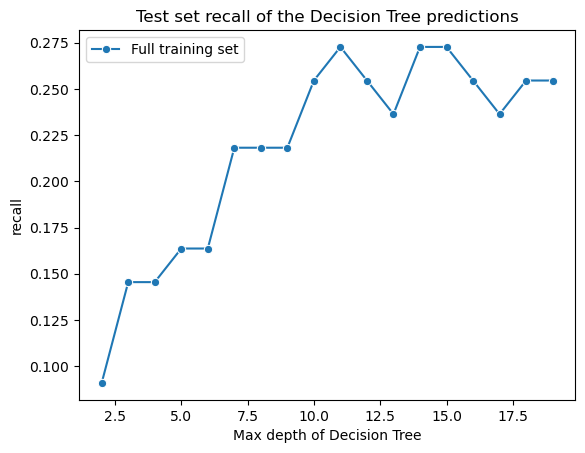

In [359]:
# specify the min number of samples to create a leaf as 1 for this
# first iteration
min_samples_to_create_leaf = 5

# initialize an empty list to store results
metrics_list = []

# iterate on the list of max depths
for iter_max_depth_value in MAX_TREE_DEPTH_RANGE:
    # train the model and store the accuracy
    resulting_metrics = train_test_DT(X_train, X_test, y_train, y_test,
                          min_samples_to_create_leaf, iter_max_depth_value)
    # print(f'Max Depth= {md} accuracy score: {score}')

    # add the results to the list for future plotting
    metrics_list.append(float(resulting_metrics[METRIC_TO_MEAUSRE]))

fig = plt.figure()
ax = fig.add_subplot(111)
p = sns.lineplot(x=MAX_TREE_DEPTH_RANGE, y=metrics_list, marker="o", label="Full training set")

plt.title(f"Test set {METRIC_TO_MEAUSRE} of the Decision Tree predictions")
ax.set_xlabel("Max depth of Decision Tree")
ax.set_ylabel(METRIC_TO_MEAUSRE)
plt.show()

# Storing the best value for hyperparameter: Maximum Tree Depth

In [360]:
# best max depth value found:
OPTIMUM_MAX_DEPTH = 2

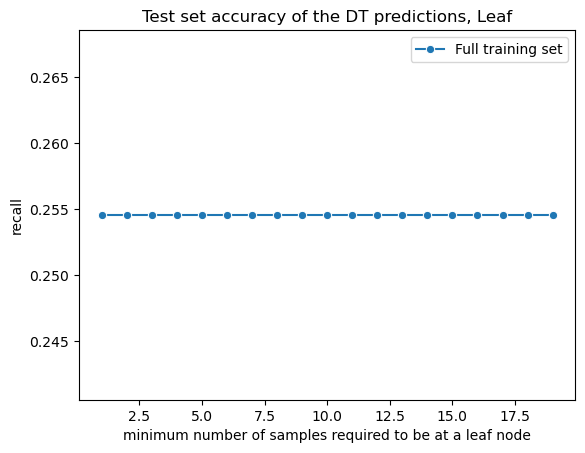

In [361]:
# initialize an empty list to store results
metrics_list_leaf = []

# iterate through list of potential leaf values
for leaf in MIN_SAMPLES_TO_MAKE_LEAF_RANGE:
    score = train_test_DT(X_train, X_test, y_train, y_test, leaf,
                          OPTIMUM_MAX_DEPTH)
    # print(f'Leaf = {leaf}, accuracy score: {score}')
    metrics_list_leaf.append(float(resulting_metrics[METRIC_TO_MEAUSRE]))

fig = plt.figure()
ax = fig.add_subplot(111)
p = sns.lineplot(x=MIN_SAMPLES_TO_MAKE_LEAF_RANGE, y=metrics_list_leaf,
                 marker="o",
                 label="Full training set")

plt.title("Test set accuracy of the DT predictions, Leaf")
ax.set_xlabel("minimum number of samples required to be at a leaf node")
ax.set_ylabel(METRIC_TO_MEAUSRE)
plt.show()


# Storing the best value for hyperparameter: Leaf

In [362]:
OPTIMUM_LEAF = 2

# Run the final model

In [363]:
# run the final model that uses both of the optimum values:
final_metrics = train_test_DT(X_train, X_test, y_train, y_test, OPTIMUM_LEAF, OPTIMUM_MAX_DEPTH)
final_metrics
# print(f"Maximum accuracy score: {score:.4}")

{'accuracy': 0.7782258064516129,
 'f1': 0.15384615384615385,
 'precision': 0.5,
 'recall': 0.09090909090909091}

# Optimizing hyperparmeters

In [364]:
# calculate options
# dims = (len(MIN_SAMPLES_TO_MAKE_LEAF_RANGE)+1, len(MAX_TREE_DEPTH_RANGE)+1)
# metrics_3d = np.ones(dims)

for METRIC_TO_MEAUSRE in ['accuracy', 'f1', 'precision', 'recall']:
    best_leaf = 0
    best_depth = 0
    best_metric = 0

    for r, iter_leaf in enumerate(MIN_SAMPLES_TO_MAKE_LEAF_RANGE):
        for c, iter_max_depth_value in enumerate(MAX_TREE_DEPTH_RANGE):
            # train the model and store the accuracy
            resulting_metrics = train_test_DT(X_train, X_test, y_train, y_test,
                                iter_leaf, iter_max_depth_value)
            
            # need to optimize so I don't have to loop through this 4 times
            met = resulting_metrics[METRIC_TO_MEAUSRE]
            if met > best_metric:
                best_leaf = iter_leaf
                best_depth = iter_max_depth_value
                best_metric = met
        
    print(f'Best leaf value = {best_leaf:4}, Best max depth = {best_depth:4}, resulted in highest value of {METRIC_TO_MEAUSRE:10} = {best_metric:.5}')

# Best leaf value =    9, Best max depth =    2, resulted in highest value of accuracy   = 0.79032
# Best leaf value =    4, Best max depth =   14, resulted in highest value of f1         = 0.34043
# Best leaf value =    9, Best max depth =    2, resulted in highest value of precision  = 0.71429
# Best leaf value =    1, Best max depth =   16, resulted in highest value of recall     = 0.30909

Best leaf value =    9, Best max depth =    2, resulted in highest value of accuracy   = 0.79032
Best leaf value =    4, Best max depth =   14, resulted in highest value of f1         = 0.34043
Best leaf value =    9, Best max depth =    2, resulted in highest value of precision  = 0.71429
Best leaf value =    1, Best max depth =   16, resulted in highest value of recall     = 0.30909


# Attemping to Plot 3D

In [365]:
# import matplotlib.pyplot as plt

# from mpl_toolkits.mplot3d import axes3d

# ax = plt.figure().add_subplot(projection='3d')
# # X, Y, Z = axes3d.get_test_data(0.05)

# # print(Z)
# # print(len(Z))
# # print(len(X[0]))

# # x = y = np.arange(-3.0, 3.0, delta)
# X, Y = np.meshgrid(MIN_SAMPLES_TO_MAKE_LEAF_RANGE, MAX_TREE_DEPTH_RANGE)
# print(X)
# print(len(X))
# print(len(X[0]))

# # X = np.array(metrics_3d[:,0])
# # Y = np.array(metrics_3d[:,1])
# # Z = np.array(metrics_3d[:,3])

# # X = MIN_SAMPLES_TO_MAKE_LEAF_RANGE
# # Y = MAX_TREE_DEPTH_RANGE
# # Z = 'TBD'

# # X = np.array(MIN_SAMPLES_TO_MAKE_LEAF_RANGE)
# # Y = np.array(MAX_TREE_DEPTH_RANGE)
# # Z = np.array(metrics_3d)
# Z = metrics_3d

# # print(Z)
# # print(type(Z))


# # # Plot the 3D surface
# ax.plot_surface(X, Y, Z, edgecolor='royalblue', lw=0.5, rstride=8, cstride=8,
#                 alpha=0.3)
# ax.set_xlabel('X-axis', linespacing=3.2)
# ax.set_ylabel('Y-axis', linespacing=3.2)
# ax.set_zlabel('Z-axis', linespacing=3.2)